Episode 0/500 - Steps: 141, Epsilon: 0.99
Episode 10/500 - Steps: 43, Epsilon: 0.95
Episode 20/500 - Steps: 3, Epsilon: 0.90
Episode 30/500 - Steps: 12, Epsilon: 0.86
Episode 40/500 - Steps: 24, Epsilon: 0.81
Episode 50/500 - Steps: 18, Epsilon: 0.77
Episode 60/500 - Steps: 19, Epsilon: 0.74
Episode 70/500 - Steps: 2, Epsilon: 0.70
Episode 80/500 - Steps: 7, Epsilon: 0.67
Episode 90/500 - Steps: 1, Epsilon: 0.63
Episode 100/500 - Steps: 60, Epsilon: 0.60
Episode 110/500 - Steps: 40, Epsilon: 0.57
Episode 120/500 - Steps: 63, Epsilon: 0.55
Episode 130/500 - Steps: 11, Epsilon: 0.52
Episode 140/500 - Steps: 11, Epsilon: 0.49
Episode 150/500 - Steps: 34, Epsilon: 0.47
Episode 160/500 - Steps: 1, Epsilon: 0.45
Episode 170/500 - Steps: 10, Epsilon: 0.42
Episode 180/500 - Steps: 35, Epsilon: 0.40
Episode 190/500 - Steps: 40, Epsilon: 0.38
Episode 200/500 - Steps: 1, Epsilon: 0.37
Episode 210/500 - Steps: 18, Epsilon: 0.35
Episode 220/500 - Steps: 17, Epsilon: 0.33
Episode 230/500 - Steps: 4,

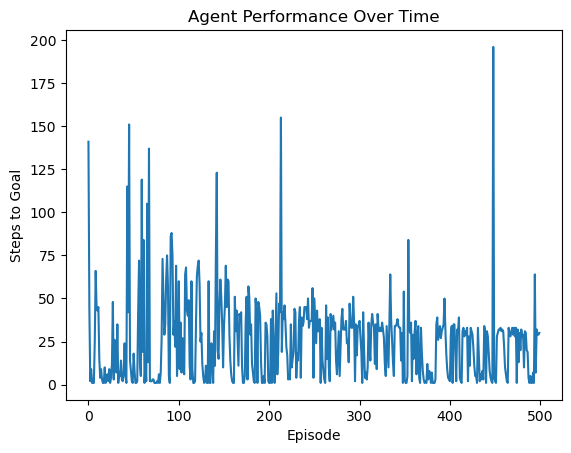

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# Load predefined city map
def load_city_map():
    city_map = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])
    return city_map

# Initialize the Q-learning agent
class Agent:
    def __init__(self, state_shape, action_size):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.state_shape),
            Conv2D(64, (3, 3), activation='relu'),
            Flatten(),
            Dense(64, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Define reward function
def compute_reward(agent_pos, goal_pos, collision):
    if collision:
        return -100
    elif agent_pos == goal_pos:
        return 100
    else:
        return -1

# Helper function to move the agent
def move_agent(pos, action, city_map):
    x, y = pos
    rows, cols = city_map.shape

    if action == 0 and x > 0 and city_map[x - 1, y] != 1:  # Up
        return x - 1, y
    elif action == 1 and x < rows - 1 and city_map[x + 1, y] != 1:  # Down
        return x + 1, y
    elif action == 2 and y > 0 and city_map[x, y - 1] != 1:  # Left
        return x, y - 1
    elif action == 3 and y < cols - 1 and city_map[x, y + 1] != 1:  # Right
        return x, y + 1
    elif action == 4:  # Stop
        return pos
    return pos

# Function to simulate vehicles
class Vehicle:
    def __init__(self, start_pos, steps):
        self.pos = start_pos
        self.steps_remaining = steps
        self.direction = random.choice([0, 1, 2, 3])

    def move(self, city_map):
        if self.steps_remaining <= 0:
            return None
        next_pos = move_agent(self.pos, self.direction, city_map)
        if next_pos != self.pos:
            self.pos = next_pos
        else:
            self.direction = random.choice([0, 1, 2, 3])
        self.steps_remaining -= 1
        return self.pos

# Main training loop
def train_agent(episodes=500):
    city_map = load_city_map()
    start_pos = tuple(np.argwhere(city_map == 2)[0])
    goal_pos = tuple(np.argwhere(city_map == 4)[0])
    agent = Agent(state_shape=(city_map.shape[0], city_map.shape[1], 1), action_size=5)
    vehicles = []

    results = []
    for episode in range(episodes):
        state = city_map[np.newaxis, :, :, np.newaxis]
        agent_pos = start_pos
        done = False
        total_steps = 0

        while not done:
            if random.random() < 0.02:
                start_points = list(zip(*np.where(city_map == 3)))
                if start_points:
                    vehicles.append(Vehicle(random.choice(start_points), random.randint(15, 150)))

            for vehicle in vehicles:
                vehicle_pos = vehicle.move(city_map)
                if vehicle_pos is None:
                    vehicles.remove(vehicle)

            action = agent.act(state)
            next_pos = move_agent(agent_pos, action, city_map)
            collision = next_pos in [v.pos for v in vehicles]
            reward = compute_reward(next_pos, goal_pos, collision)
            next_state = city_map[np.newaxis, :, :, np.newaxis]
            done = next_pos == goal_pos or collision

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent_pos = next_pos
            total_steps += 1

            if done or total_steps >= 200:
                results.append(total_steps)
                break

        if len(agent.memory) > 32:
            agent.replay(32)

        if episode % 10 == 0:
            print(f"Episode {episode}/{episodes} - Steps: {total_steps}, Epsilon: {agent.epsilon:.2f}")

    return results

# Train the agent
results = train_agent()

# Plot results
plt.plot(results)
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.title('Agent Performance Over Time')
plt.show()
